# Click Click Photography Image Classification

Whats left to do:
* Write-up
* Presentation
* Document/comment code
* Depending on prediction-score classify the image into a folder automatically
* Interaction for user for deciding which group the image should go in
* Other/better model than resnet50!!
* Doing oversampling in prepare_data class - But doesn't seem to work too well... Better suggestions?
* A lot of parameters are still hardcoded in the classes. Maybe move them to the calls in this notebook?
* ...

## Setup

### Libraries

In [1]:
# DS Tools
import numpy as np
import pandas as pd
import os
from glob import glob
import itertools
from collections import Counter
from timeit import default_timer as timer
import tqdm


# Visualizations
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
plt.rcParams['font.size'] = 14

# Image manipulations
from PIL import Image

# Splitting
from sklearn.model_selection import train_test_split

# Neural Networks
import torch
from torch import Tensor, nn, optim, cuda
import torch.nn as nn
from torch.nn.functional import interpolate
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
#from torchsummary import summary
from torch.utils.data import DataLoader, sampler

# Error handling
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

### User defined functions and classes

In [2]:
from src.prepare_data import prepare_data
from src.nn_class import nn_class

### Constants

In [3]:
# Where the input images are located
PATH = f"images_final/"

# Directories for model
traindir = f"data/train"
validdir = f"data/val"
testdir = f"data/test"

### Prepare data for the model
This step takes the given input data, splits between train/test/validation. For the training step, it also oversamples, in order to combat class imbalanced.
Doesn't return anything, but sets up the images in the correct folder, oversampled

In [4]:
#prepare_data(PATH, traindir, validdir, testdir, do_oversampling = True, oversampling = 3)

## Neural network model
Load model (and/or train)
Might need to disable load_checkpoint() two cells down if running for the first time

In [5]:
nnc = nn_class(batch_size = 128, traindir=traindir, validdir=validdir, testdir=testdir)

Train on gpu: True
1 gpus detected.
True False
There are 5 different classes.


### Choose a model 
Currently only resnet work, but I suspect it is trivial to get the remaining two up and running. I __THINK__ only `set_model` needs to be fixed.

Choose one, and let the remaining be commented out.

_(Also comment out `load_checkpoint` if this is your first time running for that model)_

In [6]:
nnc.set_model('resnet50', describe_model=False) # Set to true to see which model we built
#nnc.set_model('resnet18', describe_model=False) # Set to true to see which model we built
#nnc.set_model('wide_resnet50_2', describe_model=False) # Set to true to see which model we built

# These ones don't work (yet?) - But suspect they are promising, IFF we get them up
#nnc.set_model('vgg16', describe_model=False) # Set to true to see which model we built
#nnc.set_model('alexnet', describe_model=False) # Set to true to see which model we built


nnc.load_checkpoint()

24,033,861 total parameters.
525,829 total gradient parameters.


In [7]:
nnc.run_train(early_stopping = 5, n_epochs = 12)
nnc.save_checkpoint()

Model has been trained for: 25 epochs.

Epoch: 0	100.00% complete. 7.59 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 1.3200 	Validation Loss: 1.3727
		Training Accuracy: 45.71%	 Validation Accuracy: 41.86%
Epoch: 1	100.00% complete. 7.50 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.3319 	Validation Loss: 1.3455
		Training Accuracy: 44.94%	 Validation Accuracy: 42.98%
Epoch: 2	100.00% complete. 7.51 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 1.3280 	Validation Loss: 1.3553
		Training Accuracy: 45.90%	 Validation Accuracy: 43.39%
Epoch: 3	100.00% complete. 8.56 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 1.3253 	Validation Loss: 1.3479
		Training Accuracy: 45.04%	 Validation Accuracy: 43.95%
Epoch: 4	100.00% complete. 8.64 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 1.3373 	Validation Loss: 1.3547
		Training Accuracy: 43.41%	 Validation Accuracy: 43.53%
Epoch: 5	100.00% complete. 7.52 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 1.3268 	Validatio

### See how the training performs

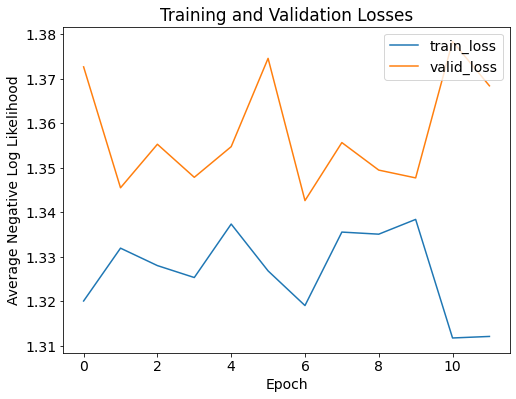

In [8]:
nnc.plot_history()

## predict

### Draw a random prediction

In [9]:
# Define the threshold
threshold = 0.4

# Draw a random image
img_selected = nnc.random_test_image()

# Run prediction (Bad coding; stolen directly from class)
img, ps, classes, y_obs = nnc.predict(img_selected, topk=5)


# Check if we can predict
if ps[0] > threshold:
    print(f"We predict {classes[0]} with {ps[0]*100} confidence%")
    print(f"true class was {y_obs}")    
    # Do stuff, such as moving to correct folder
else:
    print(f"Couldn't confidently predict a single label, guiding user with this:")
    nnc.display_prediction(img_selected, topk=5)
    # Maybe make a form for user to move to folder?

We predict fear with 42.94246733188629 confidence%
true class was fear


## Predict on all photos

In [10]:
# Define the threshold
threshold = 0.5

categories = nnc.get_categories()

preds = []
true = []

top1_true = 0
top2_true = 0
top3_true = 0
top4_true = 0
top5_true = 0

count = 0
#c = np.random.choice(self.categories)
for c in categories:
    root = testdir +"/"+ c + '/'
    imgs = os.listdir(root)
    for img in imgs:
        count = count +1 
        img_path = root + img
        
        img, ps, classes, y_obs = nnc.predict(img_path, topk=5)
        # Check if we can predict
        if ps[0] > threshold:
            print(f"We predict {classes[0]} with {ps[0]*100} confidence%. true class was {y_obs}")
            # Do stuff, such as moving to correct folder
            preds.append(classes[0])
            true.append(y_obs)
        else:
            print("did not accuractely predict")
            #print(f"Couldn't confidently predict a single label, guiding user with this:")
            #nnc.display_prediction(img_selected, topk=5)
            # Maybe make a form for user to move to folder?
        if classes[0] == y_obs:
            top1_true = top1_true +1
            top2_true = top2_true +1
            top3_true = top3_true +1
            top4_true = top4_true +1
            top5_true = top5_true +1
        if classes[1] == y_obs:
            top2_true = top2_true +1
            top3_true = top3_true +1
            top4_true = top4_true +1
            top5_true = top5_true +1
        if classes[2] == y_obs:
            top3_true = top3_true +1
            top4_true = top4_true +1
            top5_true = top5_true +1
        if classes[3] == y_obs:
            top4_true = top4_true +1
            top5_true = top5_true +1
        if classes[4] == y_obs:
            top5_true = top5_true +1

did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 54.41485047340393 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 58.62601399421692 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 53.028541803359985 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
We predict happy with 60.48774719238281 confidence%. true class was happy
We predict happy with 67.67697930335999 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 62.18079328536987 c

did not accuractely predict
We predict happy with 72.53153920173645 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
We predict happy with 79.3982982635498 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 59.60701107978821 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 51.27959847450256 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict happy with 85.33611297607422 confidence%. true class was happy
We predict happy with 55.01771569252014 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
We predict happy with 78.92566919326782 confidence%. true class was happy
did not accuractely predict
did not accuractely predict
did not

did not accuractely predict
did not accuractely predict
We predict fear with 59.197551012039185 confidence%. true class was fear
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict fear with 52.644509077072144 confidence%. true class was fear
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
did not accuractely predict
We predict fear with 55.2947461605072 confidence%. true class was fear
did not accuractely predict
We predict fear with 59.197551012039185 confidence%. true class was fear
did not accuractely predict
did not ac

In [11]:
a = preds
b = true

acc = sum(1 for x,y in zip(a,b) if x == y) / len(a)

print(f"Predicted on {len(a)} images ({100*len(a) / count})% of the dataset. got an accuracy of {100*acc}%")

Predicted on 111 images (15.459610027855152)% of the dataset. got an accuracy of 79.27927927927928%


In [12]:
print(f" our top 1 guess was correct {top1_true} times - meaning a accuracy of {100 * top1_true/count} %")
print(f" our top 2 guess was correct {top2_true} times - meaning a accuracy of {100 * top2_true/count} %")
print(f" our top 3 guess was correct {top3_true} times - meaning a accuracy of {100 * top3_true/count} %")
print(f" our top 4 guess was correct {top4_true} times - meaning a accuracy of {100 * top4_true/count} %")
print(f" our top 5 guess was correct {top5_true} times - meaning a accuracy of {100 * top5_true/count} %")

 our top 1 guess was correct 317 times - meaning a accuracy of 44.15041782729805 %
 our top 2 guess was correct 462 times - meaning a accuracy of 64.34540389972145 %
 our top 3 guess was correct 610 times - meaning a accuracy of 84.958217270195 %
 our top 4 guess was correct 679 times - meaning a accuracy of 94.56824512534818 %
 our top 5 guess was correct 718 times - meaning a accuracy of 100.0 %


In [13]:
count

718

### Predict from imagepath
This is a starting point for the actual task... Currently drawing a random sample of 10

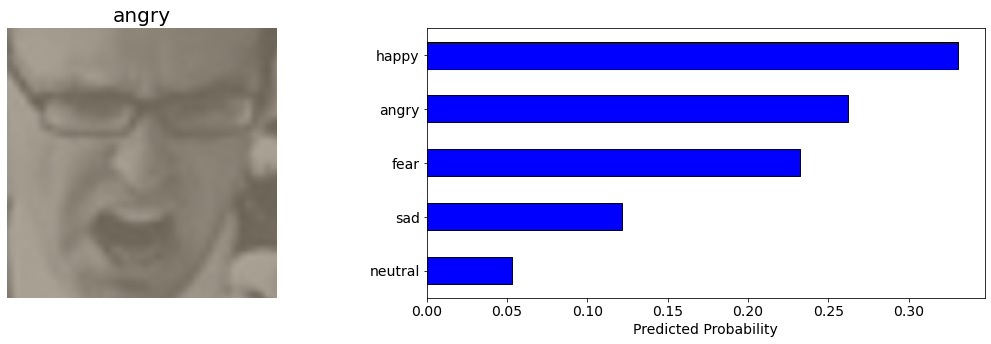

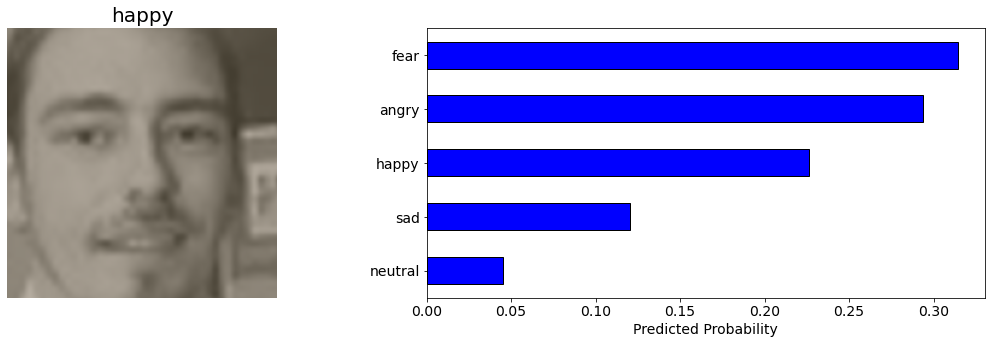

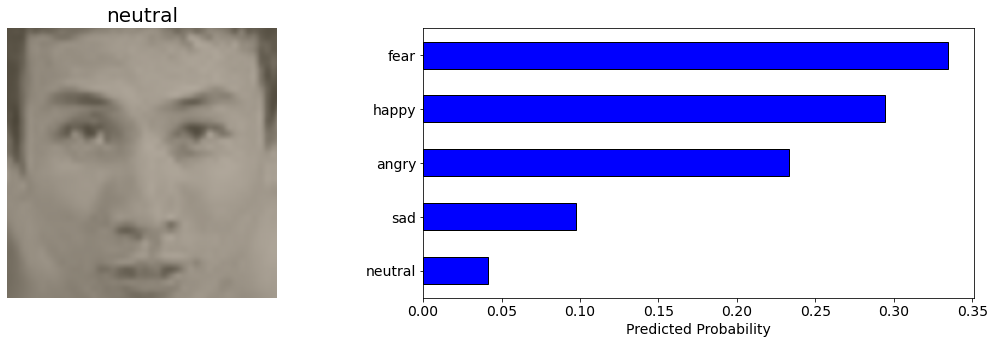

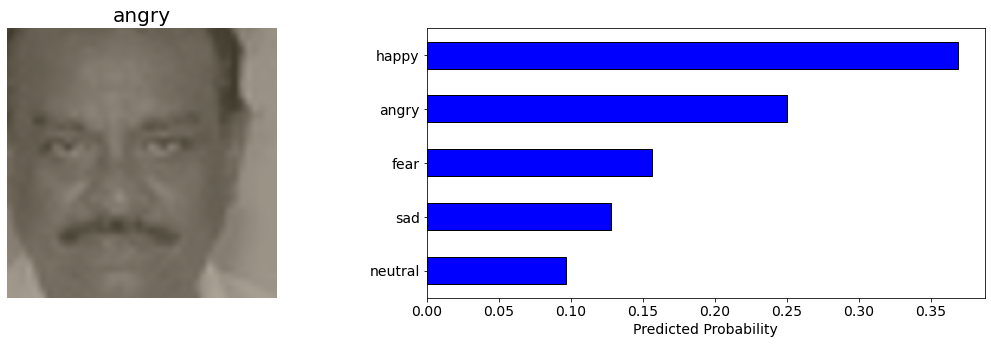

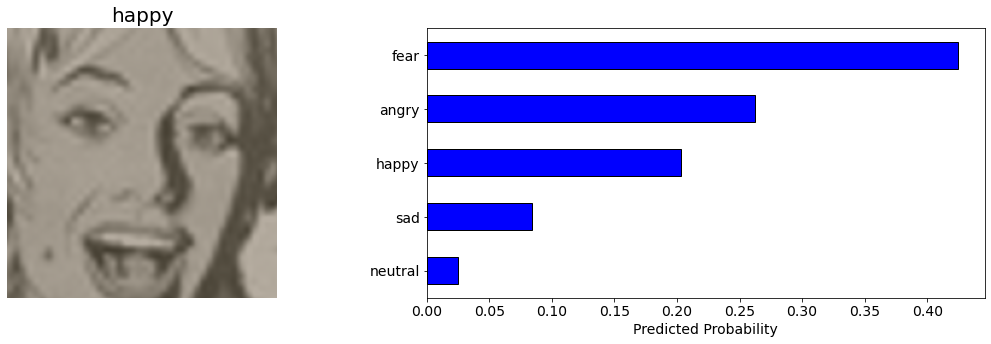

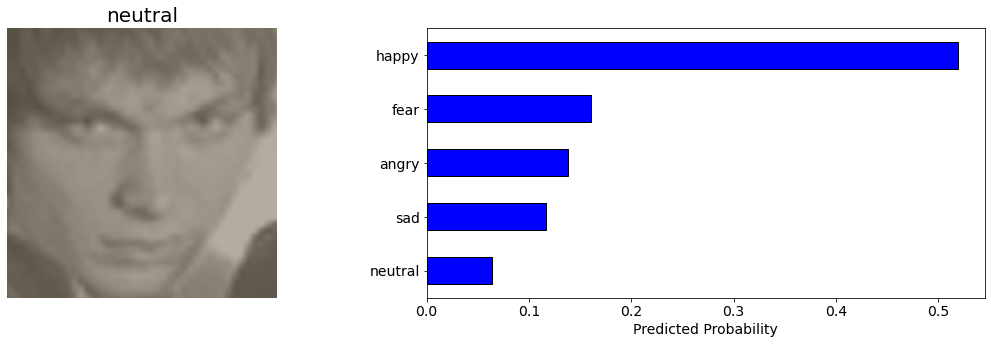

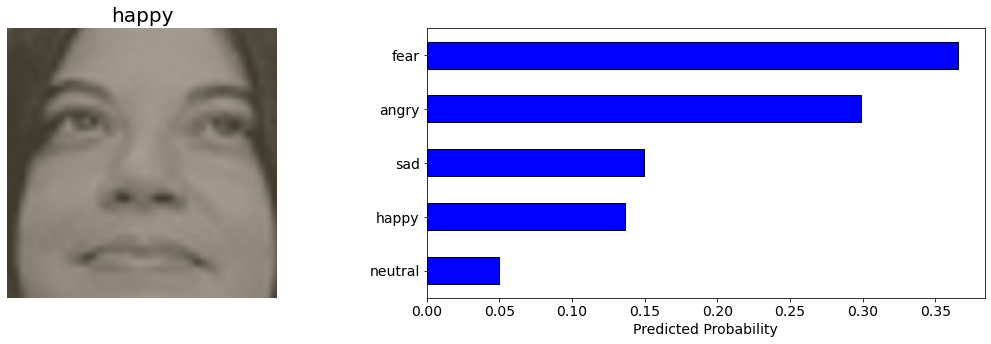

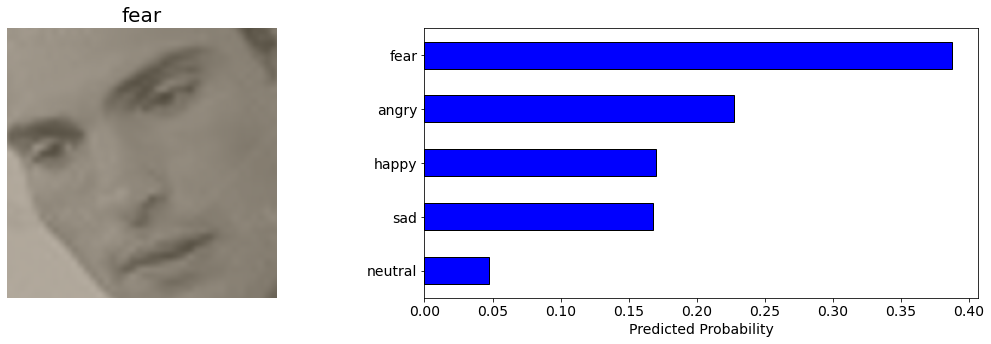

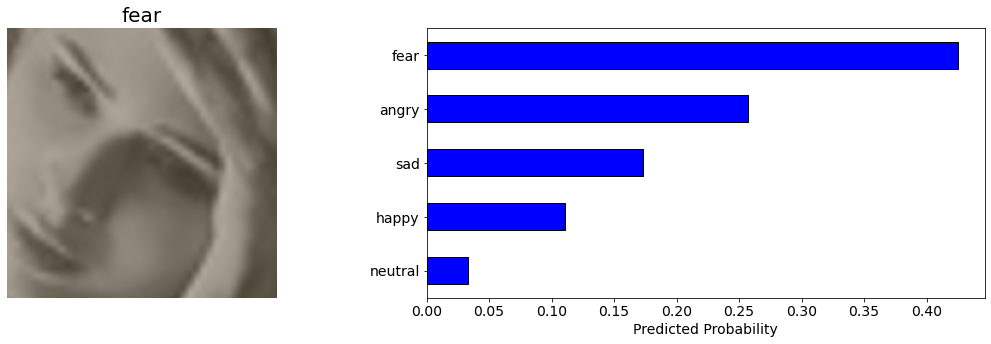

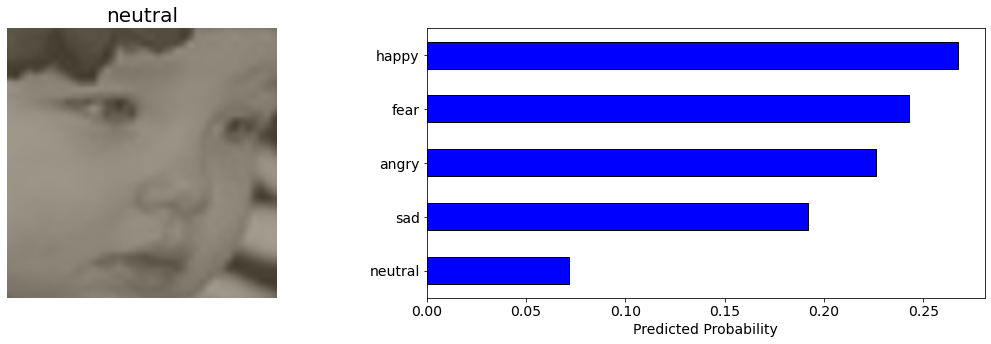

In [14]:
for i in range(10):
    root = testdir +"/"+ np.random.choice(nnc.get_categories()) + '/'
    img_path = root + np.random.choice(os.listdir(root))
    nnc.display_prediction(img_path, topk=5)